In [1]:
!git clone https://github.com/IanXie168/Individual_Project_For_INFO_5604.git

Cloning into 'Individual_Project_For_INFO_5604'...
remote: Enumerating objects: 1057, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 1057 (delta 2), reused 0 (delta 0), pack-reused 1040
Receiving objects: 100% (1057/1057), 71.18 MiB | 17.75 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
cd /content/Individual_Project_For_INFO_5604

/content/Individual_Project_For_INFO_5604


In [3]:
import random
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from dataset import RadarSets
from convlstm import ConvLSTM

In [4]:
## exaim the device type（recommendation for using GPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Training datasets and validation datasets


In [5]:
## training dataset path
data_dir = '/content/Individual_Project_For_INFO_5604/Train.csv'
example = pd.read_csv(data_dir, header=None)
path = example.values.tolist()

## parameter configurations
device = 'cuda:0'
height = 128
width = 128
bs = 10
lr = 0.001  ## 
num_epochs = 500
train_ratio = 0.7 ## 0.9
path = np.array(path)
nums = 943

## 90% for training; 10% for validation
tnums = int(nums*train_ratio) 
values = np.array(range(nums))

## split traning datasets and testing datasets
random.shuffle(values)
path = path[values]
train_path = path[:tnums]
valid_path = path[tnums:]

## the dataset path of radar reflectiivty patterns
data_path = '/content/Individual_Project_For_INFO_5604/radar_train'
train_sets = RadarSets(train_path, data_path, (height, width), mode='train')
valid_sets = RadarSets(valid_path, data_path, (height, width), mode='valid')
train_loader = DataLoader(train_sets, batch_size=bs, num_workers=8,pin_memory=True, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_sets, batch_size=bs, num_workers=8,pin_memory=True, shuffle=False, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# build model

In [6]:
# build 3 layer ConvLSTM model
model = ConvLSTM(input_dim=1,
                 hidden_dim=[64, 64, 1],
                 kernel_size=(3, 3),
                 num_layers=3,  
                 batch_first=True,
                 bias=True,
                 return_all_layers=True)
## load device
model = model.to(device)
model

## now let's try 4 layers
## build 4 layer ConvLSTM model
# model = ConvLSTM(input_dim=1,
#                  hidden_dim=[64, 64, 32, 1],
#                  kernel_size=(3, 3),
#                  num_layers=4,  
#                  batch_first=True,
#                  bias=True,
#                  return_all_layers=True)
# ## load device
# model = model.to(device)

## now let's try 4 layers
## build 4 layer ConvLSTM model
## change the traing/test dataset ratio into 0.7 (train_ratio)
# model = ConvLSTM(input_dim=1,
#                  hidden_dim=[64, 64, 32, 1],
#                  kernel_size=(3, 3),
#                  num_layers=4,  
#                  batch_first=True,
#                  bias=True,
#                  return_all_layers=True)
# ## load device
# model = model.to(device)

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(65, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

# model training and saving

In [7]:
MAX_EPOCH = 10
loss_func = lambda pred, obs: (F.l1_loss(pred, obs, reduction='mean') + F.mse_loss(pred, obs, reduction='mean'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# for lr in np.arange(0.001, 0.01, 0.002):
#   MAX_EPOCH = 10
#   loss_func = lambda pred, obs: (F.l1_loss(pred, obs, reduction='mean') + F.mse_loss(pred, obs, reduction='mean'))
#   optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#   for epoch in range(MAX_EPOCH):
#       total_loss = 0
#       model.train()
#       for i, (inputs, targets) in enumerate(train_loader):
#           torch.multiprocessing.freeze_support()
#           optimizer.zero_grad()
#           inputs, targets = inputs.cuda(0), targets.cuda(0)
#           torch.cuda.empty_cache()
#           layer_output_list, last_state_list = model(inputs)
#           last_layer_output = layer_output_list[-1]
#           #last_layer_last_h, last_layer_last_c = last_state_list[-1]
#           loss = loss_func(last_layer_output, targets)
#           loss.backward()
#           optimizer.step()
#           total_loss += loss.item()

#       ave_loss = total_loss/len(train_loader)    

#       ## print training information
#       print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f}".format(
#           epoch+1, MAX_EPOCH, i+1, len(train_loader), total_loss/len(train_loader))) 

#   ## save ConvLSTM model
#   torch.save(model.state_dict(), str(lr)+'_convlstm_model_lr.pth')
#   print('saved model sucessfully')

Training:Epoch[001/010] Iteration[066/066] Loss: 0.0337
Training:Epoch[002/010] Iteration[066/066] Loss: 0.0304
Training:Epoch[003/010] Iteration[066/066] Loss: 0.0305
Training:Epoch[004/010] Iteration[066/066] Loss: 0.0300
Training:Epoch[005/010] Iteration[066/066] Loss: 0.0304
Training:Epoch[006/010] Iteration[066/066] Loss: 0.0304
Training:Epoch[007/010] Iteration[066/066] Loss: 0.0298
Training:Epoch[008/010] Iteration[066/066] Loss: 0.0301
Training:Epoch[009/010] Iteration[066/066] Loss: 0.0299
Training:Epoch[010/010] Iteration[066/066] Loss: 0.0298
saved model sucessfully
Training:Epoch[001/010] Iteration[066/066] Loss: 0.0395
Training:Epoch[002/010] Iteration[066/066] Loss: 0.0327
Training:Epoch[003/010] Iteration[066/066] Loss: 0.0307
Training:Epoch[004/010] Iteration[066/066] Loss: 0.0324
Training:Epoch[005/010] Iteration[066/066] Loss: 0.0309
Training:Epoch[006/010] Iteration[066/066] Loss: 0.0320
Training:Epoch[007/010] Iteration[066/066] Loss: 0.0308
Training:Epoch[008/010] 

# model predictoin and evaluation

In [8]:
## Invoke ConvLSTM model (the saved model)
model = model.to(device)
model.load_state_dict(torch.load('/content/Individual_Project_For_INFO_5604/model/convlstm_model.pth',map_location='cpu'))
model.eval()
for inputs, targets in tqdm(valid_loader):
    torch.multiprocessing.freeze_support()
    optimizer.zero_grad()
    inputs, targets = inputs.cuda(0), targets.cuda(0)
    torch.cuda.empty_cache()
    layer_output_list, last_state_list = model(inputs)
    last_layer_output = layer_output_list[-1]
    #last_layer_last_h, last_layer_last_c = last_state_list[-1]
    loss = loss_func(last_layer_output, targets)
    loss.backward()
    optimizer.step()

100%|██████████| 28/28 [00:53<00:00,  1.91s/it]


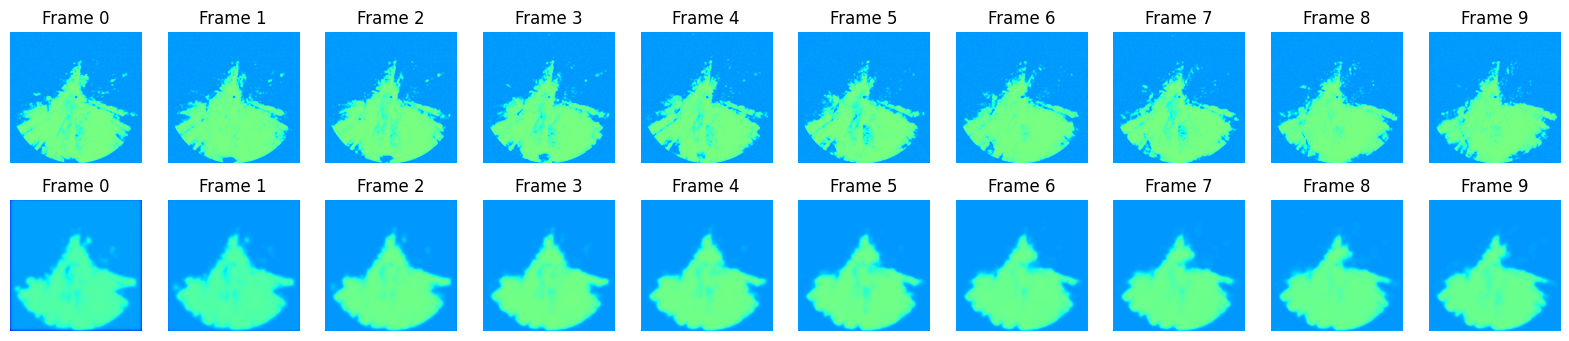

In [11]:
## create two raws, ten columns figure canvas (The first row: true results, second row: simulation results)
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

## plot the true results
for idx, ax in enumerate(axes[0]):
    image = np.clip(targets.squeeze()[3,idx].cpu().detach().numpy(), 0, 1) * 255
    img = np.array(Image.fromarray(image).resize((640, 640), Image.ANTIALIAS))
    ax.imshow(img, vmin=0, vmax=255, cmap='jet')
    ax.set_title(f"Frame {idx}")
    ax.axis("off")

## plot the simulation results
for idx, ax in enumerate(axes[1]):
    image = np.clip(last_layer_output.squeeze()[3,idx].cpu().detach().numpy(), 0, 1) * 255
    img = np.array(Image.fromarray(image).resize((640, 640), Image.ANTIALIAS))
    ax.imshow(img, vmin=0, vmax=255, cmap='jet')
    ax.set_title(f"Frame {idx}")
    ax.axis("off")
plt.show()

# model evaluation metrics

In [12]:
from skimage.metrics import peak_signal_noise_ratio as psnr  
from PIL import Image  
import numpy as np  

def calc_psnr(idx):  
    """
    PSNR（Peak Signal to Noise Ratio）:
    That is, the ratio between the energy of peak signal and the average energy of noise. Usually,
     log is taken to become decibels (dB) when it is expressed. Since MSE (mean square error) is the average energy 
     difference between the real image and the image with noise, and the difference between the two is noise,
    PSNR is the ratio between the energy of peak signal and MSE. The calculation formula is as follows:

    PSNR = 10log((MaxValue ^ 2) / MSE) = 20*log(MaxValue) - 10*log(MSE)

    The PSNR calculates the PSNR ratio in decibels amid two images. We often use this ratio as a measurement of quality between the original image and the resultant image. 
    The higher the value of PSNR, the better will be the quality of the output image

    Maxvalue is the maximum number that represents the color of an image point, or 255 if each sampling point is represented in 8 bits
    """

    image = np.clip(targets.squeeze()[3,idx].cpu().detach().numpy(), 0, 1) * 255
    img1 = np.array(Image.fromarray(image).resize((640, 640), Image.ANTIALIAS))

    image = np.clip(last_layer_output.squeeze()[3,idx].cpu().detach().numpy(), 0, 1) * 255
    img2 = np.array(Image.fromarray(image).resize((640, 640), Image.ANTIALIAS))

    img1, img2 = np.array(img1), np.array(img2)  
 
    psnr_score = psnr(img1, img2, data_range=255)  
    return psnr_score

In [13]:
psnr_score_list = []
for i in range(10):
    psnr_score = calc_psnr(idx =i)
    psnr_score_list.append(psnr_score)

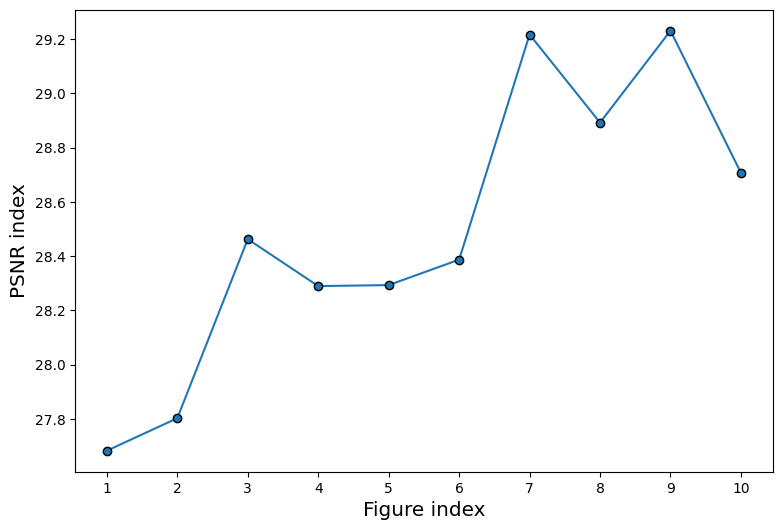

In [20]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(np.arange(1,11),psnr_score_list,marker='o',mec='k')
ax.set_ylabel('PSNR index', fontsize='x-large')
ax.set_xlabel('Figure index', fontsize='x-large')
ax.set_xticks(np.arange(1,11))